# 安装依赖环境

如果没有使用 Azure Notebook 并且在本地运行代码示例，则需要执行以下步骤来安装 Python scikit-learn 包和 Azure ML SDK。

你将使用 NumPy 和 scikit-learn 处理示例数据，两者都是适用于 Python 的常用科学包。 你还需要安装 Azure ML SDK，它会将你连接到 Azure 机器学习服务工作区。

你可以执行以下命令将所需包安装到 Python 环境。



In [1]:
pip install -U scikit-learn azureml-sdk


The following command must be run outside of the IPython shell:

    $ pip install -U scikit-learn azureml-sdk

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more information on how to install packages:

    https://docs.python.org/3/installing/


这将安装几个相关包，这些包有助于在 Python 中处理数据。

# 加载并检索 MNIST 数据

在笔记本单元中运行以下代码，检索 MNIST 数据集并将其保存到本地“data”文件夹。

In [2]:
import os
import urllib.request

#create a folder for the dataset
os.makedirs('./data', exist_ok = True)

# load dataset to the directory--as you can see, you must load train sets and test sets separately
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', filename='./data/train-images.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', filename='./data/train-labels.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', filename='./data/test-images.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', filename='./data/test-labels.gz')

('./data/test-labels.gz', <http.client.HTTPMessage at 0x7f1aa2de5b38>)

你将看到如下所示的输出：('./data/test-labels.gz', <http.client.HTTPMessage at 0x7f1aa2de5b38>)。 将创建名为“data”的文件夹，其中包含四个 Gzipped 文件，这些文件包含图像及标签测试和训练数据。

# 拆分数据集

下一步骤为将数据拆分为训练集和测试集。 我们将需要一个函数来加载压缩文件并返回可处理的 numpy 数组。

In [3]:
import gzip
import numpy as np
import struct

# load compressed MNIST gz files and return numpy arrays
def load_data(filename, label=False):
    with gzip.open(filename) as gz:
        struct.unpack('I', gz.read(4))
        n_items = struct.unpack('>I', gz.read(4))
        if not label:
            n_rows = struct.unpack('>I', gz.read(4))[0]
            n_cols = struct.unpack('>I', gz.read(4))[0]
            res = np.frombuffer(gz.read(n_items[0] * n_rows * n_cols), dtype=np.uint8)
            res = res.reshape(n_items[0], n_rows * n_cols)
        else:
            res = np.frombuffer(gz.read(n_items[0]), dtype=np.uint8)
            res = res.reshape(n_items[0], 1)
    return res

print('Functions defined')

Functions defined


定义 load_data helper 函数后，现可使用它通过以下代码加载数据。

In [4]:
# To help the model converge faster, shrink the intensity values (X) from 0-255 to 0-1

X_train = load_data('./data/train-images.gz', False) / 255.0
y_train = load_data('./data/train-labels.gz', True).reshape(-1)

X_test = load_data('./data/test-images.gz', False) / 255.0
y_test = load_data('./data/test-labels.gz', True).reshape(-1)

print('Data loaded')

Data loaded


# 显示示例图像

为了验证是否已加载数据，接下来使用 matplotlib 显示其中一个示例，即“图像 + 标签”。 这可能需要一到两分钟时间才能运行。

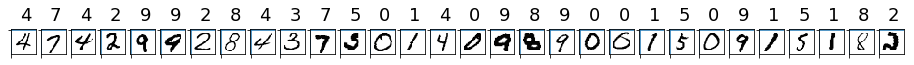

Done


In [5]:
%matplotlib inline 

import matplotlib.pyplot as plt
import numpy as np


count = 0
sample_size = 30
plt.figure(figsize = (16, 6))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x=10, y=-10, s=y_train[i], fontsize=18)
    plt.imshow(X_train[i].reshape(28, 28), cmap=plt.cm.Greys)
    
plt.show()

print('Done')

顶部行的数字是标签，手写图片在第二行。

# 使用 Scikit-Learn 运行逻辑回归模型

逻辑回归算法是当响应变量是分类变量时使用的回归模型。 为此，导入常用 scikit-learn 包来实现算法。

使用以下代码运行逻辑回归模型并精确打印模型。 这可能需要几分钟才能完成执行。

忽略可能出现的FutureWaring

In [7]:
from sklearn.linear_model import LogisticRegression

#load the model
clf = LogisticRegression()
#fit the model
clf.fit(X_train, y_train)

#evaluate the model by using a test set
y_hat = clf.predict(X_test)
#print the accuracy
print(np.average(y_hat == y_test))

print('Done')

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.9201
Done


# 创建机器学习服务工作区


创建试验的第一步是创建机器学习服务工作区。 我们可以使用 Azure ML SDK 在 Azure 门户或者 Python 中执行此操作。 若要使用 Python，我们将需要提供 Azure 订阅 ID。可以通过左侧边栏中的“订阅”项，或者在全局搜索框中键入“订阅”，在 Azure 门户中查找订阅。

找到要使用的订阅，并将下面的 {azure-subscription-id} 值替换为订阅 ID 值。 如果尚未登录到 Azure 帐户，SDK 会要求你登录


In [9]:
from azureml.core import Workspace,Experiment,Run

ws = Workspace.create(
            name='AMLSWorkspace',
            subscription_id='b8f29da2-9485-446b-8531-af35ce23d1bc', 
            resource_group='rgAMLSLearnworkspace',
            create_resource_group=True,
            location='eastus2'
)

Deploying AppInsights with name amlsworkinsights57227b58.
Deployed AppInsights with name amlsworkinsights57227b58. Took 71.66 seconds.
Deploying KeyVault with name amlsworkkeyvaultb9aab60f.
Deployed KeyVault with name amlsworkkeyvaultb9aab60f. Took 102.22 seconds.
Deploying StorageAccount with name amlsworkstorage20a50635e.
Deployed StorageAccount with name amlsworkstorage20a50635e. Took 123.14 seconds.
Deploying Workspace with name AMLSWorkspace.
Deployed Workspace with name AMLSWorkspace. Took 51.38 seconds.


提示：Workspace.create 函数返回创建的 Workspace 对象，随着步骤的继续进行，我们将使用该对象。 现在我们将其存储在变量 ws 中。

# 创建试验和作业

凭借 Workspace 对象，可以使用 Azure ML SDK 创建 Experiment 和 run：

In [10]:
from azureml.core import Experiment
#Create an experiment
experiment = Experiment(workspace = ws, name = "my-first-experiment")

#Create a run
run = experiment.start_logging()
run.log("trial",1)
run.complete()

作业完成后，下方代码将显示有关已运行作业的详细信息。

In [11]:
from azureml.widgets import RunDetails

RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

可在 Azure 门户中查看试验的运行情况。 使用以下代码打印链接至最后一次运行的结果的 URL：

In [12]:
print(run.get_portal_url())

https://ml.azure.com/experiments/my-first-experiment/runs/49803859-0dd8-4a92-a25e-3e4ee0feaee7?wsid=/subscriptions/b8f29da2-9485-446b-8531-af35ce23d1bc/resourcegroups/rgAMLSLearnworkspace/workspaces/AMLSWorkspace


#  创建远程计算目标

你已了解计算目标是用于运行训练脚本或托管服务部署的计算资源。现在，将创建一个 Azure 机器学习计算 (AmlCompute) 作为计算资源。 AmlCompute 是针对由 Azure 机器学习服务直接管理的机器学习工作负载优化的计算目标。 无需连接或配置这些目标 - 系统会自动完成。

第一步是创建远程计算目标：

In [13]:
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget
import os

# Step 1: name the cluster and set the minimal and maximal number of nodes 
compute_name = os.environ.get("AML_COMPUTE_CLUSTER_NAME", "cpucluster")
min_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MIN_NODES", 0)
max_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MAX_NODES", 3)

# Step 2: choose environment variables 
vm_size = os.environ.get("AML_COMPUTE_CLUSTER_SKU", "STANDARD_D2_V2")

provisioning_config = AmlCompute.provisioning_configuration(
    vm_size = vm_size, min_nodes = min_nodes, max_nodes = max_nodes)

# create the cluster
compute_target = ComputeTarget.create(ws, compute_name, provisioning_config)

print('Compute target created')

Compute target created


# 导入并检索 MNIST 数据 （可选）

如果你还没有执行“练习 - 加载用于简单逻辑回归模型的数据”，则需要运行以下代码来获取此试验的数据。

In [14]:
import os
import urllib.request

#create a folder for the dataset
os.makedirs('./data', exist_ok = True)

# load dataset to the directory--as you can see, you must load train sets and test sets separately
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', filename='./data/train-images.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', filename='./data/train-labels.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', filename='./data/test-images.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', filename='./data/test-labels.gz')

print('Done')

Done


# 加载数据并创建建模脚本

有多种方法可以将数据传输到模型中，具体取决于数据源的位置和格式。 例如，可使用所创建的 Workspace 对象获取默认数据存储，并将数据上传到 Azure Blob 存储。

In [15]:
#upload data by using get_default_datastore()
ds = ws.get_default_datastore()
ds.upload(src_dir='./data', target_path='mnist', overwrite=True, show_progress=True)

print('Done')

Uploading an estimated of 4 files
Uploading ./data/test-images.gz
Uploading ./data/test-labels.gz
Uploading ./data/train-images.gz
Uploading ./data/train-labels.gz
Uploaded ./data/test-labels.gz, 1 files out of an estimated total of 4
Uploaded ./data/train-labels.gz, 2 files out of an estimated total of 4
Uploaded ./data/test-images.gz, 3 files out of an estimated total of 4
Uploaded ./data/train-images.gz, 4 files out of an estimated total of 4
Uploaded 4 files
Done


然后，创建一个目录，用于保存训练用 Python 代码：

In [16]:
import os

# create the folder
folder_training_script = './trial_model_mnist'
os.makedirs(folder_training_script, exist_ok=True)

print('Done')

Done


最后，准备模型训练脚本（注意在此脚本中，你要定义两个参数）：

第一个参数用于查找云端数据或设置数据路径。
算法中的另一个参数，即正则化参数。

In [17]:
%%writefile ./data/train.py

import argparse
import os
import numpy as np
import glob

from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib

from azureml.core import Run
# from utils import load_data

import gzip
import struct

# load compressed MNIST gz files and return numpy arrays
def load_data(filename, label=False):
    with gzip.open(filename) as gz:
        struct.unpack('I', gz.read(4))
        n_items = struct.unpack('>I', gz.read(4))
        if not label:
            n_rows = struct.unpack('>I', gz.read(4))[0]
            n_cols = struct.unpack('>I', gz.read(4))[0]
            res = np.frombuffer(gz.read(n_items[0] * n_rows * n_cols), dtype=np.uint8)
            res = res.reshape(n_items[0], n_rows * n_cols)
        else:
            res = np.frombuffer(gz.read(n_items[0]), dtype=np.uint8)
            res = res.reshape(n_items[0], 1)
    return res


# let user feed in 2 parameters, the dataset to mount or download, and the regularization rate of the logistic regression model
parser = argparse.ArgumentParser()
parser.add_argument('--data-folder', type=str, dest='data_folder', help='data folder mounting point')
parser.add_argument('--regularization', type=float, dest='reg', default=0.01, help='regularization rate')
args = parser.parse_args()

###
data_folder = os.path.join(args.data_folder, 'mnist')
print('Data folder:', data_folder)

# load the train and test set into numpy arrays
X_train = load_data(os.path.join(data_folder, 'train-images.gz'), False) / 255.0
X_test = load_data(os.path.join(data_folder, 'test-images.gz'), False) / 255.0

#print variable set dimension
print(X_train.shape, X_test.shape, sep = '\n')

y_train = load_data(os.path.join(data_folder, 'train-labels.gz'), True).reshape(-1)
y_test = load_data(os.path.join(data_folder, 'test-labels.gz'), True).reshape(-1)

#print the response variable dimension
print( y_train.shape, y_test.shape, sep = '\n')

# get hold of the current run
run = Run.get_context()

print('Train a logistic regression model with regularization rate of', args.reg)
clf = LogisticRegression(C=1.0/args.reg, solver="liblinear", multi_class="auto", random_state=42)
clf.fit(X_train, y_train)

print('Predict the test set')
y_hat = clf.predict(X_test)

# calculate accuracy on the prediction
acc = np.average(y_hat == y_test)
print('Accuracy is', acc)

run.log('regularization rate', np.float(args.reg))
run.log('accuracy', np.float(acc))

os.makedirs('outputs', exist_ok=True)
# note file saved in the outputs folder is automatically uploaded into experiment record
joblib.dump(value=clf, filename='outputs/sklearn_mnist_model.pkl')

Writing ./data/train.py


请注意，训练脚本的最后一行将该模型保存为试验工作区 outputs 文件夹中的 pickle 文件。 稍后你将使用此 pickle 文件来部署模型。

估算器对象用于提交运行。 通过运行以下代码创建估算器以定义：

估算器对象的名称 est。
包含脚本的目录。 此目录中的所有文件都上传到群集节点以便运行。
计算目标。 在此示例中，将使用所创建的 Azure 机器学习计算群集。
训练脚本名称“train.py”。
训练脚本所需的参数。
训练所需的 Python 包。

In [18]:
from azureml.train.sklearn import SKLearn

script_params = {
    '--data-folder': ds.as_mount(),
    '--regularization': 0.5
}

#import the Scikit-learn package 
est = SKLearn(source_directory='./data/',
                script_params=script_params,
                compute_target=compute_target,
                entry_script='train.py',
                conda_packages=['scikit-learn'])


WARNING - You have specified to install packages in your run. Note that you have overridden Azure ML's installation of the following packages: ['scikit-learn']. We cannot guarantee image build will succeed.


# 提交模型、监视运行并检索结果

我们需要创建一个 Experiment，以便在其中运行模型训练。

In [19]:
from azureml.core import Experiment

#Create an experiment
experiment = Experiment(workspace = ws, name = "amls-learn-experimentnew5")

print('Experiment created')

Experiment created


最后一步是运行模型。 如果系统提示登录，请使用 Azure 帐户登录。

In [24]:
run = experiment.submit(config=est)
run

Experiment,Id,Type,Status,Details Page,Docs Page
amls-learn-experimentnew5,amls-learn-experimentnew5_1575253852_4af15695,azureml.scriptrun,Starting,Link to Azure Machine Learning studio,Link to Documentation


可以使用“azureml”包中的小组件模块来监视运行：

In [26]:
# monitor the run
from azureml.widgets import RunDetails

RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

此次运行完成后，可以打印结果。 结果的记录始于在训练脚本中编写代码后。

In [27]:
#get the result
print(run.get_metrics())

{'regularization rate': 0.5, 'accuracy': 0.9193}


可选：检索工作区设置

In [28]:
ws.get_details()

{'id': '/subscriptions/b8f29da2-9485-446b-8531-af35ce23d1bc/resourceGroups/rgAMLSLearnworkspace/providers/Microsoft.MachineLearningServices/workspaces/AMLSWorkspace',
 'name': 'AMLSWorkspace',
 'location': 'eastus2',
 'type': 'Microsoft.MachineLearningServices/workspaces',
 'sku': 'Basic',
 'workspaceid': 'fd5d35ee-6f0e-4f72-bd13-74ac3685e8c9',
 'description': '',
 'friendlyName': 'AMLSWorkspace',
 'creationTime': '2019-12-02T01:56:52.9798741+00:00',
 'keyVault': '/subscriptions/b8f29da2-9485-446b-8531-af35ce23d1bc/resourcegroups/rgamlslearnworkspace/providers/microsoft.keyvault/vaults/amlsworkkeyvaultb9aab60f',
 'applicationInsights': '/subscriptions/b8f29da2-9485-446b-8531-af35ce23d1bc/resourcegroups/rgamlslearnworkspace/providers/microsoft.insights/components/amlsworkinsights57227b58',
 'identityPrincipalId': '340d0ad0-ede2-42cb-8bce-37a308079c19',
 'identityTenantId': '20ff436e-cbc0-4fe3-b0d3-76918d3d0d8b',
 'identityType': 'SystemAssigned',
 'storageAccount': '/subscriptions/b8f29

# 使用 Python 注册 Azure ML 模型

使用 Azure 门户或 Python 创建工作区后，可在工作区中注册模型以供将来使用。 与容器注册表相似，模型注册表也是一个位置，用于跟踪 Azure 机器学习服务中的所有模型，其目的在于确保以结构化格式存储模型。

在我们用于训练模型的训练脚本中，最后一步是将模型保存为 pickle 文件。 你将注册此文件以进行部署。

要运行以下代码，需要训练模型并将其保存到 pickle 文件中，如“使用 Azure 机器学习服务训练本地模型”单元中所述。

In [29]:
model = run.register_model(model_name='sklearn_mnist_model.pkl',
                           model_path='outputs/sklearn_mnist_model.pkl',
                           tags = {'area': "MNIST", 'type': "sklearn"},
                           description = "identify numbers")

print(model.name, model.id, model.version, sep='\t')

sklearn_mnist_model.pkl	sklearn_mnist_model.pkl:1	1


在上述代码中，我们在模型中添加了 tags 和 description，以便于搜索。 使用 tags，可以跟踪模型用途、名称、用于训练模型的机器学习库版本等有用信息。注意，标记必须使用字母和数字。

# 创建评分脚本

由于机器学习模型始终依赖 PyTorch 等其他依赖项，所以用户可使用容器映像可靠地部署模型。 使用容器部署机器学习模型可以避免依赖项问题。

容器映像打包以下你需要准备的项：

模型本身
推理引擎，如 PyTorch
评分文件 (score.py) 或其他使用模型的应用程序
任何所需依赖项

第一步是创建使用模型的 score.py 文件，如下所示。 只需定义两个函数：加载模型的 init 和执行推理的 run：

In [30]:
%%writefile score.py
from sklearn.externals import joblib
from sklearn.linear_model import Ridge
from azureml.core.model import Model
import numpy
import json

def init():
    global model
    model_path = Model.get_model_path('sklearn_mnist_model.pkl')
    # deserialize the model file back into a sklearn model
    model = joblib.load(model_path)

# note you can pass in multiple rows for scoring
def run(raw_data):
    try:
        data = json.loads(raw_data)['data']
        data = numpy.array(data)
        result = model.predict(data)
        # you can return any datatype if it is JSON-serializable
        return result.tolist()
    except Exception as e:
        error = str(e)
        return error

Writing score.py


# 创建环境 YAML 文件

第二步是确保映像中包含依赖项。 Azure 机器学习通过创建 conda 依赖项文件完成此步骤

In [31]:
from azureml.core.conda_dependencies import CondaDependencies 

myenv = CondaDependencies.create(conda_packages=['numpy','scikit-learn'])

with open("myenv.yml","w") as f:
    f.write(myenv.serialize_to_string())

print('Done')

Done


# 创建训练模型的容器映像

如果你已完成上述单元“使用 Python 注册 Azure ML 模型”，则该模型已注册成功。 但为方便使用模型对象变量，请使用以下代码再次注册。

In [32]:
# register model
model = run.register_model(model_name='sklearn_mnist_model.pkl',
                           model_path='outputs/sklearn_mnist_model.pkl')

print(model.name, model.id, model.version, sep='\t')

sklearn_mnist_model.pkl	sklearn_mnist_model.pkl:2	2


现在，准备容器映像。 以下 Python 代码使用 Azure ML SDK 来创建映像。

In [33]:
from azureml.core.image import Image, ContainerImage

image_config = ContainerImage.image_configuration(runtime= "python",
                                 execution_script="score.py",
                                 conda_file="myenv.yml",
                                 tags = {'data': "MNIST", 'type': "sklearn"},
                                 description = "Image for sklearn model")

image = Image.create(name = "myimage1",
                     # this is the model object 
                     models = [model],
                     image_config = image_config, 
                     workspace = ws)

image.wait_for_creation(show_output = True)

print('Done')

Creating image
Running......................................
Succeeded
Image creation operation finished for image myimage1:1, operation "Succeeded"
Done


执行代码后，你可以在 Azure 机器学习服务门户中查看映像

# 将模型部署为 Web 服务

现在，我们拥有包含训练模型的映像，我们可以使用 Azure 容器实例将训练模型部署为 Web 服务。 涉及以下两个步骤：

定义部署配置。 部署配置定义了要创建为模型创建的计算，用于对应用程序进行评分。 例如，以下代码定义使用 1 个 CPU 和 1 GB 内存的容器：


In [34]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores = 1, 
                                          memory_gb = 1, 
                                          tags = {"data": "mnist", "type": "sklearn"}, 
                                          description = 'Handwriting recognition')

print('Done')

Done


在之前的单元中，你创建了一个映像并将其存储在一个名为“image”的对象中。 要部署该映像，可以使用与以下代码类似的代码：

In [35]:
from azureml.core.webservice import Webservice

service_name = 'aci-mnist-1'

service = Webservice.deploy_from_image(deployment_config = aciconfig,
                                            image = image,
                                            name = service_name,
                                            workspace = ws)

service.wait_for_deployment(show_output = True)

print('Done')

Running...............
Succeeded
ACI service creation operation finished, operation "Succeeded"
Done


部署 Web 服务大约需要 3 到 4 分钟。 部署后，可以从客户端应用程序调用该服务。

# 使用部署的模型为数据评分

由于模型部署为公开 REST API 的 Web 服务，因此可以使用多种工具对其进行测试。 Azure 机器学习 SDK 具有可用于部署的 Web 服务的内置测试工具，如下所示：

In [36]:
import os 

import gzip
import struct
import numpy as np


# load compressed MNIST gz files and return numpy arrays
def load_data(filename, label=False):
    with gzip.open(filename) as gz:
        struct.unpack('I', gz.read(4))
        n_items = struct.unpack('>I', gz.read(4))
        if not label:
            n_rows = struct.unpack('>I', gz.read(4))[0]
            n_cols = struct.unpack('>I', gz.read(4))[0]
            res = np.frombuffer(gz.read(n_items[0] * n_rows * n_cols), dtype=np.uint8)
            res = res.reshape(n_items[0], n_rows * n_cols)
        else:
            res = np.frombuffer(gz.read(n_items[0]), dtype=np.uint8)
            res = res.reshape(n_items[0], 1)
    return res

data_folder = os.path.join(os.getcwd(), 'data')

# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the neural network converge faster
X_test = load_data(os.path.join(data_folder, 'test-images.gz'), False) / 255.0
y_test = load_data(os.path.join(
    data_folder, 'test-labels.gz'), True).reshape(-1)

print('Done')

Done


现在，用下面的代码对一些数据进行评分。

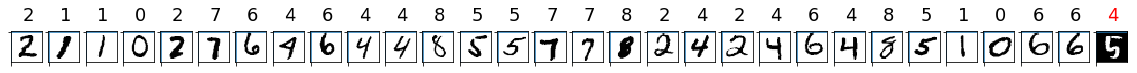

In [37]:
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# find 30 random samples from test set
n = 30
sample_indices = np.random.permutation(X_test.shape[0])[0:n]

test_samples = json.dumps({"data": X_test[sample_indices].tolist()})
test_samples = bytes(test_samples, encoding='utf8')

# predict using the deployed model
result = service.run(input_data=test_samples)

# compare actual value vs. the predicted values:
i = 0
plt.figure(figsize=(20, 1))
#plt.figure(figsize=(9, 3))

for s in sample_indices:
    plt.subplot(1, n, i + 1)
    plt.axhline('')
    plt.axvline('')

    # use different color for misclassified sample
    font_color = 'red' if y_test[s] != result[i] else 'black'
    clr_map = plt.cm.gray if y_test[s] != result[i] else plt.cm.Greys
    plt.text(x=10, y=-10, s=result[i], fontsize=18, color=font_color)
    plt.imshow(X_test[s].reshape(28, 28), cmap=clr_map)

    i = i + 1

plt.show()

代码的关键部分是 service.run 调用，该调用将 JSON 格式的文档发送到部署的 Web 服务并显示结果。

你还可以使用 REST API 来调用模型。 以下代码将调用模型来识别从数组中随机选择的数字。

In [44]:
import requests

# send a random row from the test set to score
random_index = np.random.randint(0, len(X_test)-1)
input_data = "{\"data\": [" + str(list(X_test[random_index])) + "]}"

headers = {'Content-Type': 'application/json'}

# for AKS deployment you'd need to include the service key in the header as well
# api_key = service.get_key()
# headers = {'Content-Type':'application/json',  'Authorization':('Bearer '+ api_key)} 

resp = requests.post(service.scoring_uri, input_data, headers=headers)

print("POST to url", service.scoring_uri)
#print("input data:", input_data)
print("label:", y_test[random_index])
print("prediction:", resp.text)

POST to url http://059aeeb0-8f0d-4fb5-bb9a-ea8191eb7dba.eastus2.azurecontainer.io/score
label: 9
prediction: [9]
